# Synergy Analytics

The purpose of this notebook is to explore, clean, analyse and lastly attempt to forecast few of the future values of parameters within the Hursley House, a building own by IBM Corp. The full data of different parameters related to comfort level has been supplied by IBM and was given to our group among others by UCL Electronics and Electrical Engineering Department. 

Structure of the notebook: 
- Loading and retreiving relevant .csv files
- Converting them into usable formats 
- Performing some basic data cleansing and preparation which would help our models. These include identifying blank entries and replacing them with overall average values, identifying outliers, plotting them and replacing them too with average values, indexing the data with timestamps and then sorting the timestamps, clustering the full raw data into 7 distinct rooms data within the building in order to achieve more accurate results for each room and develop a more useful energy profile for each room.
- Developing a simple Artificial Neural Networks (ANN) to predict the value of the temperature based on the historic data. In doing so, we have used a specific version of ANN's called Recurrent Neural Nets (RNN), which have proven to perform well on timseries data according on literature.
- Providing means for this model to be deployed to the cloud (Node-red platform), in order to create a responsive and real-time IoT system with embedded rules and logic.

Note: I have deliberately avoided removing values based on duplicate timestamps, since not only that will reduce the size of the data considerably (1151 unique timestamps only), but it will fade the true characteristics of the building by taking away unique occurances during one timestamp.

# A quick note on the model used:

After researching the literature to pursue a suitable model which would fit well with a seasonal timeseries data, I ended up choosing 3 models to develop and compare and eventually stay with the best performing one. Those 3 were LMTS networks within the RNN framework, Autoregressive Conditional Heteroskedasticity (ARCH), a non-linear stochastic model built for timeseries data with low correlation between different input parameters and Autoregressive Integrated Moving Average (ARIMA) model which is widely explored in literature and has showed very promising results even for non-linear data such as weather forecasting all the way to stock markets. 

I initially started with developing the ARIMA model, here locally on the DSX platform, however, as it turns out, the library which ARIMA models are imported from, called statsmodel is not supported for deployment on DSX (as one of the IBM support guys put it, you can devdelop local models with statsmodels, but you won't be able to deploy the model that imports that library!). So unfortunately, I had to pivot to RNN framework, which uses Keras library and which is luckily built on top of TensorFlow, a library supported for deployment on DSX. I also explored Random Forrest and KNN Regression on basic levels, but unfortunately could not dive deep enough due to lack of time.

Standard precedure to import one of the asset files, in this case the full raw data that was given to us. 

In [336]:
# The code was removed by DSX for sharing.

,timestamp,date,Time,sensor,Temperature,Occupancy,Light Level,Relative Humidity,Noise Level,Pressure
0,1.475240e+12,9/30/2016,12:53,H013LS,20.1,Unoccupied,0.32,49.6,35.0,1012.034384
1,1.475240e+12,9/30/2016,12:53,H008LE,21.7,Unoccupied,0.00,46.3,35.0,1005.414723
2,1.475240e+12,9/30/2016,12:53,H008LNW,20.4,Unoccupied,0.00,51.0,35.0,1016.839134
3,1.475240e+12,9/30/2016,12:53,H019LS,19.7,Unoccupied,0.00,50.5,35.0,1011.775958
4,1.475240e+12,9/30/2016,12:53,H004LSW,20.4,Unoccupied,0.00,47.0,56.0,1014.823564


In [337]:
# The code was removed by DSX for sharing.

# Exploring the Data

Let us begin with doing some exploratory visual analysis on the raw data set. We will be plotting using different tools such as ACF plots and scatter plot matrices.

In [338]:
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import scatter_matrix
from pandas.plotting import autocorrelation_plot

Creating a scatter plot matrix in order to better understand the possible correlations between different parameters.

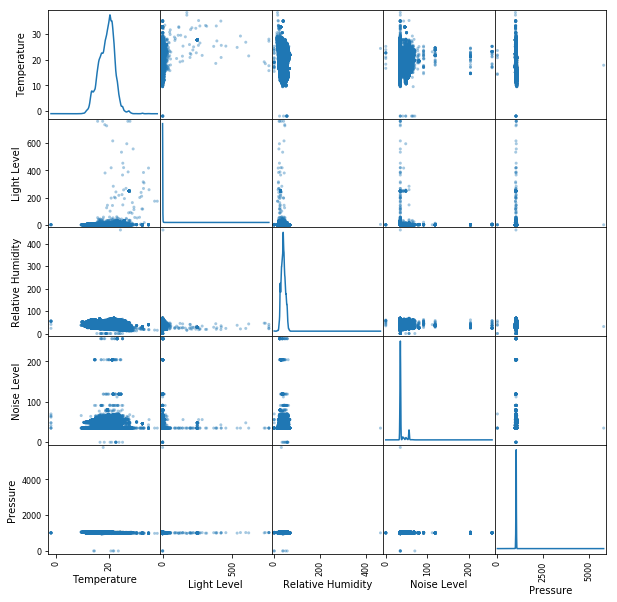

In [317]:
df_data_viz = df_data.copy()
#df_data_viz = pd.DataFrame(np.random.randn(1000, 5), columns=['Temperature', 'Light Level', 'Relative Humidity', 'Noise Level', 'Pressure'])

params=['Temperature','Light Level','Relative Humidity','Noise Level','Pressure']
scatter_matrix(df_data_viz[params], alpha=0.4, figsize=(10, 10), diagonal='kde')
plt.show()

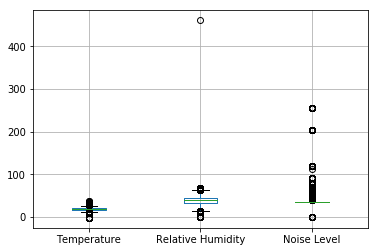

In [328]:
#pd.options.display.mpl_style = 'default'
df_data_box = df_data.copy()
df_data_box.boxplot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0b28110c18>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f0a3827fbe0>]], dtype=object)

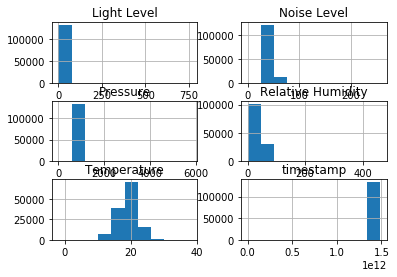

In [329]:
df_data.hist()

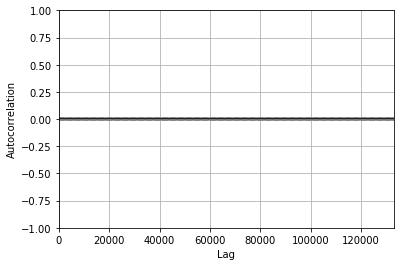

In [331]:
plt.figure()
temp_data = df_data['Temperature']
autocorrelation_plot(temp_data)

# Room Clustering

We will cluster the full data into 7 different rooms, in order to get a better picture of the behaviour pf each room and get more accurate results. We do so using the sensor ID's assign to each room in the 'sensor' column. In this process, we also manage to get rid of the garbage sensor values present in the data (for instance sensor value '00158D000083B1A9' which is undefined).

In [339]:
df_001_LNW = df_data.loc[df_data['sensor']=='H001LNW']
df_001_LW = df_data.loc[df_data['sensor']=='H001LW']

#merging the files into one file to get all the values for room 1. 
#We will also sort the values based on their timestamp index later on, assuring no inconsistency with the original data

df_001_unsorted = pd.concat([df_001_LNW, df_001_LW])

In [340]:
df_002_LNW = df_data.loc[df_data['sensor']=='H002LNW']
df_002_LSE = df_data.loc[df_data['sensor']=='H002LSE']
df_002_LSW = df_data.loc[df_data['sensor']=='H002LSW']

df_002_unsorted = pd.concat([df_002_LNW, df_002_LSE, df_002_LSW])

In [341]:
df_004_LE = df_data.loc[df_data['sensor']=='H004LE']
df_004_LSW = df_data.loc[df_data['sensor']=='H004LSW']

df_004_unsorted = pd.concat([df_004_LE, df_004_LSW])

In [342]:
df_008_LE = df_data.loc[df_data['sensor']=='H008LE']
df_008_LNE = df_data.loc[df_data['sensor']=='H008LNE']
df_008_LNW = df_data.loc[df_data['sensor']=='H008LNW']
df_008_LS = df_data.loc[df_data['sensor']=='H008LS']

df_008_unsorted = pd.concat([df_008_LE, df_008_LNE, df_008_LNW, df_008_LS])

In [343]:
df_013_LE = df_data.loc[df_data['sensor']=='H013LE']
df_013_LNE = df_data.loc[df_data['sensor']=='H013LNE']
df_013_LS = df_data.loc[df_data['sensor']=='H013LS']
df_013_LSE = df_data.loc[df_data['sensor']=='H013LSE']
df_013_LSW = df_data.loc[df_data['sensor']=='H013LSW']

df_013_unsorted = pd.concat([df_013_LE, df_013_LNE, df_013_LS, df_013_LSE, df_013_LSW])

In [344]:
df_015_LE = df_data.loc[df_data['sensor']=='H015LE']
df_015_LW = df_data.loc[df_data['sensor']=='H015LW']

df_015_unsorted = pd.concat([df_015_LE, df_015_LW])

In [345]:
df_019_LN = df_data.loc[df_data['sensor']=='H019LN']
df_019_LS = df_data.loc[df_data['sensor']=='H019LS']

df_019_unsorted = pd.concat([df_019_LN, df_019_LS])

In [346]:
#setting the index to timestamp to facilitate sorting the data
df_001_indexed = df_001_unsorted.set_index('timestamp')
df_002_indexed = df_002_unsorted.set_index('timestamp')
df_004_indexed = df_004_unsorted.set_index('timestamp')
df_008_indexed = df_008_unsorted.set_index('timestamp')
df_013_indexed = df_013_unsorted.set_index('timestamp')
df_015_indexed = df_015_unsorted.set_index('timestamp')
df_019_indexed = df_019_unsorted.set_index('timestamp')

In [347]:
#sorting the data to get back the original order, just in each room
df_001 = df_001_indexed.sort_index()
df_002 = df_002_indexed.sort_index()
df_004 = df_004_indexed.sort_index()
df_008 = df_008_indexed.sort_index()
df_013 = df_013_indexed.sort_index()
df_015 = df_015_indexed.sort_index()
df_019 = df_019_indexed.sort_index()

In [348]:
df_002.head()

,date,Time,sensor,Temperature,Occupancy,Light Level,Relative Humidity,Noise Level,Pressure
timestamp,,,,,,,,,
1.472740e+12,9/1/2016,14:26,H002LSW,23.4,Unoccupied,3.06,45.6,35.0,1011.086003
1.472740e+12,9/1/2016,14:26,H002LNW,21.9,Unoccupied,0.00,37.6,35.0,1014.563400
1.472740e+12,9/1/2016,14:26,H002LNW,21.9,Unoccupied,0.00,37.6,35.0,1014.563400
1.472740e+12,9/1/2016,14:26,H002LSW,23.2,Unoccupied,2.04,45.6,35.0,1011.508930
1.472740e+12,9/1/2016,14:26,H002LNW,23.4,Unoccupied,0.00,37.6,35.0,1013.302419


In [349]:
#resetting the indexes back to normal numerical values
df_001 = df_001.reset_index()
df_002 = df_002.reset_index()
df_004 = df_004.reset_index()
df_008 = df_008.reset_index()
df_013 = df_013.reset_index()
df_015 = df_015.reset_index()
df_019 = df_019.reset_index()

In [350]:
df_002.head()

,timestamp,date,Time,sensor,Temperature,Occupancy,Light Level,Relative Humidity,Noise Level,Pressure
0,1.472740e+12,9/1/2016,14:26,H002LSW,23.4,Unoccupied,3.06,45.6,35.0,1011.086003
1,1.472740e+12,9/1/2016,14:26,H002LNW,21.9,Unoccupied,0.00,37.6,35.0,1014.563400
2,1.472740e+12,9/1/2016,14:26,H002LNW,21.9,Unoccupied,0.00,37.6,35.0,1014.563400
3,1.472740e+12,9/1/2016,14:26,H002LSW,23.2,Unoccupied,2.04,45.6,35.0,1011.508930
4,1.472740e+12,9/1/2016,14:26,H002LNW,23.4,Unoccupied,0.00,37.6,35.0,1013.302419


# Data Cleaning

In [351]:
import numpy as np

from numpy import genfromtxt
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score
from sklearn import datasets

## Room 1 (ID : 001)

Separating Temperature data from the DataFrame to do data cleansing and preprocessing, since our focus is mainly on temperature data.

In [352]:
df_001_Temp = df_001['Temperature']

In [353]:
df_001_Temp.tail()

10861    17.5
10862    17.5
10863    17.8
10864    19.0
10865    17.4
Name: Temperature, dtype: float64

In [354]:
#Getting rid of the last value since it's not available. 
#df_Temperature = df_Temperature.drop(df_Temperature.index[len(df_Temperature)-1])

Calculating the mean value of the temperature data which will be useful in filling for the blank values and outliers later on.

In [355]:
df_001_Temp_mean = df_001_Temp.mean()

Filling in the blank values with temperature mean value.

In [356]:
df_001_Temp = df_001_Temp.fillna(df_001_Temp_mean)

Replacing the anomalies in the data with temperature mean value. Literature and other projects suggest anomalies are anything outside 3 standard deviations away from the mean data.

In [357]:
df_Temperature_anomalies = df_Temperature.copy()
df_anomalies_mean=df_Temperature_anomalies.mean()

within_zScore=df_Temperature_anomalies[np.abs(df_Temperature_anomalies-df_anomalies_mean)<=(3*df_Temperature_anomalies.std())] 
outside_zScore=df_Temperature_anomalies[(np.abs(df_Temperature_anomalies-df_anomalies_mean)>(3*df_Temperature_anomalies.std()))]

In [358]:
within_zScore.head()

0    20.1
1    21.7
2    20.4
3    19.7
4    20.4
Name: Temperature, dtype: float64

In [359]:
outside_zScore

648       28.0
875       29.1
1664      -1.9
2222      10.1
2234      10.0
2239       9.9
2242       9.9
2244       9.9
3583      28.6
3772      28.3
3774      28.2
4192      32.9
5571      30.4
5688      10.3
5693      10.2
5695      10.3
5704      10.2
5718      28.2
5720      -1.9
5864      10.1
5975      34.9
5979      34.9
6111      28.0
6841      28.0
6965      27.9
8106      32.6
8613      28.2
8877      32.6
9065      28.5
9067      28.5
          ... 
119373    10.1
119378    10.1
119394    10.0
119949    32.6
121442    32.6
122193    28.2
122196    28.2
122793    27.9
122986    32.6
123248    28.2
123275    29.2
123561    28.1
123565    28.2
124059    30.4
124380    28.0
126160     9.9
126795    28.7
127995    29.9
129984    28.0
130237    28.5
130239    28.5
130669    28.0
130671    28.0
130782    28.6
130905    32.6
131272    34.9
131377    28.2
131383    32.6
131885    32.6
132508    27.9
Name: Temperature, Length: 338, dtype: float64

As it can be seen from the data, there are 338 values out of the total 132,870 within the temperature data that are outliers and are better to be either dropped or replaced with average values. Note that outside_zScore was printed just for the sake of presentation.

In [360]:
#df_001_temp =  df_001_Temp.copy()

# dropping the outliers
df_001_Temp = df_001_Temp[np.abs(df_001_Temp - df_001_Temp.mean())<=(3*df_001_Temp.std())]

In [361]:
df_001_Temp.head()

0    19.7
1    19.7
2    19.7
3    19.7
4    19.7
Name: Temperature, dtype: float64

## Room 2 (ID : 002)

We will follow the exact same steps for temperature values in room 002 and the rest of the rooms each.

In [362]:
df_002_Temp = df_002['Temperature']
df_002_Temp_mean = df_002_Temp.mean()
df_002_Temp = df_002_Temp.fillna(df_002_Temp_mean)
df_002_Temp = df_002_Temp[np.abs(df_002_Temp - df_002_Temp.mean())<=(3*df_002_Temp.std())]

## Room 3 (ID : 004)

In [363]:
df_004_Temp = df_004['Temperature']
df_004_Temp_mean = df_004_Temp.mean()
df_004_Temp = df_004_Temp.fillna(df_004_Temp_mean)
df_004_Temp = df_004_Temp[np.abs(df_004_Temp - df_004_Temp.mean())<=(3*df_004_Temp.std())]

## Room 4 (ID : 008)

In [364]:
df_008_Temp = df_008['Temperature']
df_008_Temp_mean = df_008_Temp.mean()
df_008_Temp = df_008_Temp.fillna(df_008_Temp_mean)
df_008_Temp = df_008_Temp[np.abs(df_008_Temp - df_008_Temp.mean())<=(3*df_008_Temp.std())]

## Room 5 (ID : 013)

In [365]:
df_013_Temp = df_013['Temperature']
df_013_Temp_mean = df_013_Temp.mean()
df_013_Temp = df_013_Temp.fillna(df_013_Temp_mean)
df_013_Temp = df_013_Temp[np.abs(df_013_Temp - df_013_Temp.mean())<=(3*df_013_Temp.std())]

## Room 6 (ID : 015)

In [366]:
df_015_Temp = df_015['Temperature']
df_015_Temp_mean = df_015_Temp.mean()
df_015_Temp = df_015_Temp.fillna(df_015_Temp_mean)
df_015_Temp = df_015_Temp[np.abs(df_015_Temp - df_015_Temp.mean())<=(3*df_015_Temp.std())]

## Room 7 (ID : 019)

In [367]:
df_019_Temp = df_019['Temperature']
df_019_Temp_mean = df_019_Temp.mean()
df_019_Temp = df_019_Temp.fillna(df_019_Temp_mean)
df_019_Temp = df_019_Temp[np.abs(df_019_Temp - df_019_Temp.mean())<=(3*df_019_Temp.std())]

# Neural Network Modelling

As mentioned in the introductory section of this notebook, we have used the Recurrent Neural Nets to predict the value of internal temperature data in real-time. The following steps have been followed to reach a suitable model: 
- Cleaning and clustering the data is previously performed, so we skipped this step.
- Important: it is extremely important to format the timeseries data first to one that can be processed well with machine learning forecasting algorithms. Literature suggests taking 3 steps to do so:
    - Checking the autocorellation of the data using ACF/PACF plots which are done in the Data Exploring segment. 
    - Checking if the timeseries data's stationarity; stationary timeseries is one whose statistical properties such as mean, variance, autocorrelation, etc. are all constant over time. We do implement this step below. 
    - And lastly, taking into account the seasonality (or other trends for that purpose) within the data series. We chose to skip this part, since we do not have the full year data of the building and therefore seasonality is less of a concern.
    
- Choosing the architecture of the RNN:  for an NN to be trained based on reasonable architecture. The values that have to be set include but are not limited to Epoch number, number of nodes and layers in the NN, number of data points used that will give a good enough estimation for the rest of the data, number of training and test sets and etc. We did so following some similar projects carried out online or in literature.
- Cross-validating the data to assure we are not overfitting the model. 
- Measure performance with values such as RMSE, MAPE and so forth and ideally visualise the performance too. 

Note: training neural nets is very time consuming. Training even few thousand data points out of the roughly 130 thousand data points takes anything between 20 minutes to 2 hours, which seems very surprising since we are running on Bluemix cloud. Therefore, some comprimise had to be made on number of data sets and neurons to be trained, to achieve results before the deadline, that meant lower performance. 

In [368]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from pandas import concat
from pandas import Series

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
import numpy
from matplotlib import pyplot

from sklearn.model_selection import StratifiedKFold

Let us first define the general functions needed. 

In [369]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [370]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [371]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [372]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [373]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [374]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

In [375]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

As mentioned above, a portion of data from each room is chosen to be trained to achieve results in a reasonabel time. The performance stagnates after a certain number anyways. 

As a rule of thumb and arbitrary selection, I chose to train roughly 10% of the data of each room. This is justified by calculating roughly how long would it take for the network to be trained for each room and hence in aggregate as well.

Also, please note that since we are limited to deploying 5 models at a time, I chose 5 our of the 7 rooms in total. This should convey the idea.

In [376]:
ann_data_to_be_used_001 = df_001_Temp[:1000] #out of 10,861 values.
ann_data_to_be_used_002 = df_002_Temp[:1600] #out of 16,982 values.
ann_data_to_be_used_004 = df_004_Temp[:1800] #out of 18,743 values.
ann_data_to_be_used_008 = df_008_Temp[:2000] #out of 21,943 values.
ann_data_to_be_used_015 = df_015_Temp[:2000] #out of 21,005 values.

### 1.

In [377]:
# transform data to be stationary
raw_values_001 = ann_data_to_be_used_001.values
diff_values = difference(raw_values_001, 1)

In [378]:
raw_values_001

array([ 19.7       ,  19.7       ,  19.7       ,  19.7       ,
        19.7       ,  19.9       ,  19.9       ,  19.9       ,
        19.9       ,  19.8       ,  19.8       ,  19.8       ,
        19.8       ,  19.9       ,  19.9       ,  19.9       ,
        19.8       ,  18.7       ,  18.7       ,  18.7       ,
        22.1       ,  22.1       ,  22.1       ,  22.1       ,
        22.1       ,  22.1       ,  22.1       ,  22.1       ,
        22.1       ,  22.1       ,  22.1       ,  22.1       ,
        22.1       ,  22.1       ,  22.1       ,  22.1       ,
        22.1       ,  22.1       ,  22.1       ,  22.1       ,
        22.1       ,  22.1       ,  22.1       ,  22.1       ,
        22.1       ,  22.1       ,  22.1       ,  22.1       ,
        22.1       ,  22.1       ,  22.1       ,  22.1       ,
        22.1       ,  22.1       ,  22.1       ,  22.1       ,
        22.1       ,  22.1       ,  20.8       ,  20.8       ,
        22.1       ,  20.8       ,  22.1       ,  20.7 

In [285]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets, we chose the 80-20 rule for test-train, since massive amounts of data are not present.
train, test = supervised_values[0:-200], supervised_values[-200:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [286]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 1500, 1)

In [288]:
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[ 0.1357004 ],
       [ 0.27045292],
       [ 0.30934417],
       [ 0.31935441],
       [ 0.32221848],
       [ 0.30119628],
       [ 0.32075572],
       [ 0.32196641],
       [ 0.32303452],
       [ 0.33323479],
       [ 0.32439154],
       [ 0.32388753],
       [ 0.32340568],
       [ 0.31274253],
       [ 0.32211256],
       [ 0.32266086],
       [ 0.33320957],
       [ 0.40715086],
       [ 0.33324987],
       [ 0.32845426],
       [ 0.14783895],
       [ 0.30027813],
       [ 0.31277591],
       [ 0.321118  ],
       [ 0.32256216],
       [ 0.32311249],
       [ 0.32323807],
       [ 0.32327771],
       [ 0.32328767],
       [ 0.32329065],
       [ 0.32329136],
       [ 0.32329178],
       [ 0.32329172],
       [ 0.32329172],
       [ 0.32329172],
       [ 0.32329172],
       [ 0.32329172],
       [ 0.32329172],
       [ 0.32329172],
       [ 0.32329172],
       [ 0.32329172],
       [ 0.32329172],
       [ 0.32329172],
       [ 0.32329172],
       [ 0.32329172],
       [ 0

In [295]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    x, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, x)
    # invert scaling
    yhat = invert_scale(scaler, x, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values_001, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values_001[len(train) + i + 1]
    print('Predicted=%f, Expected=%f' % (yhat, expected))

Predicted=23.821433, Expected=22.900000
Predicted=23.331496, Expected=23.200000
Predicted=23.220735, Expected=23.400000
Predicted=23.426509, Expected=23.500000
Predicted=23.582807, Expected=23.500000
Predicted=23.660732, Expected=23.600000
Predicted=23.702994, Expected=23.600000
Predicted=23.769197, Expected=23.800000
Predicted=23.832387, Expected=23.600000
Predicted=23.892293, Expected=23.800000
Predicted=23.846435, Expected=22.400000
Predicted=23.233095, Expected=22.200000
Predicted=22.552602, Expected=22.900000
Predicted=22.603690, Expected=21.400000
Predicted=22.282973, Expected=22.200000
Predicted=21.891138, Expected=20.000000
Predicted=21.105684, Expected=20.000000
Predicted=20.255989, Expected=20.500000
Predicted=20.364747, Expected=20.100000
Predicted=20.501930, Expected=20.900000
Predicted=20.473782, Expected=20.100000
Predicted=20.705417, Expected=20.200000
Predicted=20.332113, Expected=18.500000
Predicted=19.427329, Expected=19.500000
Predicted=19.083427, Expected=19.600000


In [294]:
# Cross_validating the data with 10-fold cross validation

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

#X = dataset[:,0:8]
#Y = dataset[:,8]
# define 10-fold cross validation test harness
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X, Y):
  # create model
    model = Sequential()
    model.add(Dense(12, input_dim=8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)
    # evaluate the model
    scores = model.evaluate(X[test], Y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

TypeError: Singleton array array(0.26491280573969256) cannot be considered a valid collection.

Test RMSE: 1.006


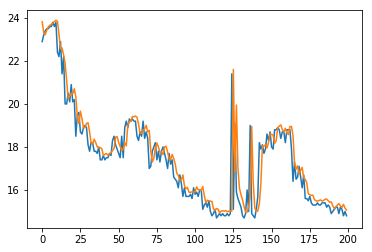

In [297]:
# report performance
rmse = sqrt(mean_squared_error(raw_values_001[-200:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values_001[-200:])
pyplot.plot(predictions)
pyplot.show()

The following code was supposed to establish a more robuts training framework, but I ended up skipping it due to complexity and time consumption.

In [298]:
# repeat experiment
#repeats = 30
#error_scores = list()
#for r in range(repeats):
    # fit the model
#    lstm_model = fit_lstm(train_scaled, 1, 1500, 1)
    # forecast the entire training dataset to build up state for forecasting
#    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
#    lstm_model.predict(train_reshaped, batch_size=1)
    # walk-forward validation on the test data
#    predictions = list()
#    for i in range(len(test_scaled)):
        # make one-step forecast
#        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
#        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
#        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
#        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
#        predictions.append(yhat)
    # report performance
    #rmse = sqrt(mean_squared_error(raw_values[81:], predictions))
    #print('%d) Test RMSE: %.3f' % (r+1, rmse))
    #error_scores.append(rmse)

# summarize results
#results = DataFrame()
#results['rmse'] = error_scores
#print(results.describe())
#results.boxplot()
#pyplot.show()

Following the exact same steps for each room.

### 2.

In [299]:
raw_values_002 = ann_data_to_be_used_002.values
diff_values = difference(raw_values_002, 1)

In [300]:
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

train, test = supervised_values[0:-320], supervised_values[-320:]

scaler, train_scaled, test_scaled = scale(train, test)

In [301]:
lstm_model = fit_lstm(train_scaled, 1, 1500, 1)

In [302]:
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[ 0.17818309],
       [ 0.31391367],
       [ 0.25903547],
       ..., 
       [ 0.03403591],
       [ 0.03096022],
       [ 0.08639588]], dtype=float32)

In [303]:
predictions = list()
for i in range(len(test_scaled)):
    X, Y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)

    yhat = invert_scale(scaler, X, yhat)

    yhat = inverse_difference(raw_values_002, yhat, len(test_scaled)+1-i)

    predictions.append(yhat)
    expected = raw_values_002[len(train) + i + 1]
    print('Predicted=%f, Expected=%f' % (yhat, expected))

Predicted=21.243708, Expected=22.900000
Predicted=22.358734, Expected=22.800000
Predicted=22.316785, Expected=21.300000
Predicted=21.792694, Expected=22.800000
Predicted=22.363455, Expected=22.300000
Predicted=22.427353, Expected=21.200000
Predicted=21.746479, Expected=21.400000
Predicted=21.666645, Expected=21.500000
Predicted=21.596585, Expected=21.200000
Predicted=21.447860, Expected=22.900000
Predicted=22.211930, Expected=20.800000
Predicted=21.539297, Expected=22.700000
Predicted=22.476319, Expected=20.800000
Predicted=21.485289, Expected=22.400000
Predicted=22.071681, Expected=22.600000
Predicted=22.330374, Expected=20.800000
Predicted=21.433549, Expected=21.400000
Predicted=21.585508, Expected=21.200000
Predicted=21.431670, Expected=22.900000
Predicted=22.207403, Expected=22.200000
Predicted=22.242174, Expected=20.800000
Predicted=21.357097, Expected=21.400000
Predicted=21.450020, Expected=21.200000
Predicted=21.364499, Expected=22.800000
Predicted=22.117688, Expected=22.700000


In [ ]:
seed = 7
numpy.random.seed(seed)

X = dataset[:,0:8]
Y = dataset[:,8]

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X, Y):
    model = Sequential()
    model.add(Dense(12, input_dim=8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)

    scores = model.evaluate(X[test], Y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

Test RMSE: 0.823


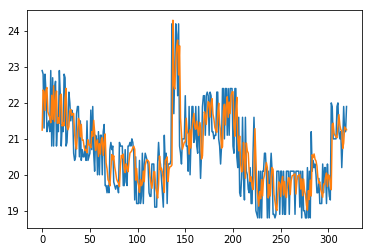

In [305]:
rmse = sqrt(mean_squared_error(raw_values_002[-320:], predictions))
print('Test RMSE: %.3f' % rmse)

pyplot.plot(raw_values_002[-320:])
pyplot.plot(predictions)
pyplot.show()

### 3.

In [379]:
raw_values_004 = ann_data_to_be_used_004.values
diff_values = difference(raw_values_004, 1)

In [380]:
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

train, test = supervised_values[0:-360], supervised_values[-360:]

scaler, train_scaled, test_scaled = scale(train, test)

In [381]:
lstm_model = fit_lstm(train_scaled, 1, 1500, 1)

In [382]:
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[ 0.24244355],
       [ 0.12272106],
       [ 0.22139499],
       ..., 
       [-0.38619307],
       [-0.35071436],
       [ 0.10746579]], dtype=float32)

In [383]:
predictions = list()
for i in range(len(test_scaled)):
    X, Y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)

    yhat = invert_scale(scaler, X, yhat)

    yhat = inverse_difference(raw_values_004, yhat, len(test_scaled)+1-i)

    predictions.append(yhat)
    expected = raw_values_004[len(train) + i + 1]
    print('Predicted=%f, Expected=%f' % (yhat, expected))

Predicted=22.712449, Expected=22.400000
Predicted=22.596533, Expected=22.400000
Predicted=22.583381, Expected=23.200000
Predicted=22.732743, Expected=23.200000
Predicted=22.776375, Expected=22.400000
Predicted=22.655296, Expected=22.400000
Predicted=22.637164, Expected=23.200000
Predicted=22.781961, Expected=22.400000
Predicted=22.663187, Expected=22.400000
Predicted=22.644809, Expected=22.400000
Predicted=22.627585, Expected=22.400000
Predicted=22.611772, Expected=22.400000
Predicted=22.597302, Expected=23.200000
Predicted=22.745464, Expected=23.200000
Predicted=22.788007, Expected=23.200000
Predicted=22.826910, Expected=23.200000
Predicted=22.862484, Expected=22.400000
Predicted=22.733630, Expected=22.400000
Predicted=22.708733, Expected=22.400000
Predicted=22.685966, Expected=23.200000
Predicted=22.826541, Expected=22.400000
Predicted=22.700960, Expected=23.200000
Predicted=22.840497, Expected=23.200000
Predicted=22.874940, Expected=22.400000
Predicted=22.746282, Expected=23.200000


In [ ]:
seed = 7
numpy.random.seed(seed)

X = dataset[:,0:8]
Y = dataset[:,8]

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X, Y):
    model = Sequential()
    model.add(Dense(12, input_dim=8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)

    scores = model.evaluate(X[test], Y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

Test RMSE: 0.574


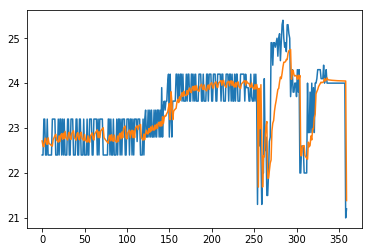

In [384]:
rmse = sqrt(mean_squared_error(raw_values_004[-360:], predictions))
print('Test RMSE: %.3f' % rmse)

pyplot.plot(raw_values_004[-360:])
pyplot.plot(predictions)
pyplot.show()

### 4.

In [385]:
raw_values_008 = ann_data_to_be_used_008.values
diff_values = difference(raw_values_008, 1)

In [386]:
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

train, test = supervised_values[0:-400], supervised_values[-400:]

scaler, train_scaled, test_scaled = scale(train, test)

In [387]:
lstm_model = fit_lstm(train_scaled, 1, 1500, 1)

In [388]:
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[ 0.26076749],
       [ 0.2674934 ],
       [-0.05985919],
       ..., 
       [ 0.2674934 ],
       [ 0.25866205],
       [-0.13726234]], dtype=float32)

In [389]:
predictions = list()
for i in range(len(test_scaled)):
    X, Y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)

    yhat = invert_scale(scaler, X, yhat)

    yhat = inverse_difference(raw_values_008, yhat, len(test_scaled)+1-i)

    predictions.append(yhat)
    expected = raw_values_008[len(train) + i + 1]
    print('Predicted=%f, Expected=%f' % (yhat, expected))

Predicted=21.097317, Expected=20.100000
Predicted=20.833348, Expected=20.100000
Predicted=20.797581, Expected=21.900000
Predicted=20.994088, Expected=21.900000
Predicted=21.097317, Expected=21.900000
Predicted=21.191794, Expected=20.100000
Predicted=20.833348, Expected=21.900000
Predicted=21.026822, Expected=21.900000
Predicted=21.127276, Expected=20.100000
Predicted=20.833348, Expected=21.900000
Predicted=21.026822, Expected=20.100000
Predicted=20.833348, Expected=20.100000
Predicted=20.797581, Expected=20.100000
Predicted=20.764847, Expected=20.100000
Predicted=20.734888, Expected=21.900000
Predicted=20.936711, Expected=21.900000
Predicted=21.044806, Expected=21.900000
Predicted=21.143735, Expected=21.900000
Predicted=21.234275, Expected=21.900000
Predicted=21.317139, Expected=21.900000
Predicted=21.392976, Expected=20.100000
Predicted=20.833348, Expected=21.900000
Predicted=21.026822, Expected=20.100000
Predicted=20.833348, Expected=21.900000
Predicted=21.026822, Expected=21.900000


In [ ]:
seed = 7
numpy.random.seed(seed)

X = dataset[:,0:8]
Y = dataset[:,8]

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X, Y):
    model = Sequential()
    model.add(Dense(12, input_dim=8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)

    scores = model.evaluate(X[test], Y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

Test RMSE: 0.592


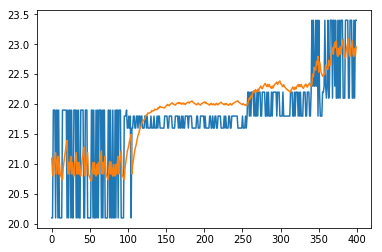

In [391]:
rmse = sqrt(mean_squared_error(raw_values_008[-400:], predictions))
print('Test RMSE: %.3f' % rmse)

pyplot.plot(raw_values_008[-400:])
pyplot.plot(predictions)
pyplot.show()

### 5.

In [392]:
raw_values_015 = ann_data_to_be_used_015.values
diff_values = difference(raw_values_015, 1)

In [393]:
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

train, test = supervised_values[0:-400], supervised_values[-400:]

scaler, train_scaled, test_scaled = scale(train, test)

In [ ]:
lstm_model = fit_lstm(train_scaled, 1, 1500, 1)

In [ ]:
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

In [ ]:
predictions = list()
for i in range(len(test_scaled)):
    X, Y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)

    yhat = invert_scale(scaler, X, yhat)

    yhat = inverse_difference(raw_values_015, yhat, len(test_scaled)+1-i)

    predictions.append(yhat)
    expected = raw_values_015[len(train) + i + 1]
    print('Predicted=%f, Expected=%f' % (yhat, expected))

In [ ]:
seed = 7
numpy.random.seed(seed)

X = dataset[:,0:8]
Y = dataset[:,8]

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
cvscores = []
for train, test in kfold.split(X, Y):
    model = Sequential()
    model.add(Dense(12, input_dim=8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X[train], Y[train], epochs=150, batch_size=10, verbose=0)

    scores = model.evaluate(X[test], Y[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
print("%.2f%% (+/- %.2f%%)" % (numpy.mean(cvscores), numpy.std(cvscores)))

In [ ]:
rmse = sqrt(mean_squared_error(raw_values_015[-400:], predictions))
print('Test RMSE: %.3f' % rmse)

pyplot.plot(raw_values_015[-400:])
pyplot.plot(predictions)
pyplot.show()

# Deployment

In [2]:
from repository.mlrepositoryclient import MLRepositoryClient
from repository.mlrepositoryartifact import MLRepositoryArtifact
from repository.mlrepository import MetaProps, MetaNames
import urllib3

In [ ]:
wml_credentials={
  "url": "https://ibm-watson-ml.eu-gb.bluemix.net",
  "access_key": "*****",
  "username": "82f5b43c-a05c-4ae1-af84-3dce95a08fdb",
  "password": "2271527a-aa1d-4aae-be83-6ca517447f33",
  "instance_id": "ffabbf01-60e9-4ed0-8916-dd1d38bc1d0c"
}

In [ ]:
ml_repository_client = MLRepositoryClient(wml_credentials['url'])
ml_repository_client.authorize(wml_credentials['username'], wml_credentials['password'])

In [ ]:
props = MetaProps({MetaNames.AUTHOR_NAME:"IBM", MetaNames.AUTHOR_EMAIL:"ibm@ibm.com"})

In [ ]:
model_artifact = MLRepositoryArtifact(model, name="Hand-written digits recognition", meta_props=props)

In [ ]:
saved_model = ml_repository_client.models.save(model_artifact)

In [ ]:
saved_model.meta.available_props()

In [ ]:
print("modelType: " + saved_model.meta.prop("modelType"))
print("runtime: " + saved_model.meta.prop("runtime"))
print("creationTime: " + str(saved_model.meta.prop("creationTime")))
print("modelVersionHref: " + saved_model.meta.prop("modelVersionHref"))

In [ ]:
loadedModelArtifact = ml_repository_client.models.get(saved_model.uid)

In [ ]:
print(loadedModelArtifact.name)
print(saved_model.uid)

In [ ]:
predictions = loadedModelArtifact.model_instance().predict(score_data)

In [ ]:
print(predictions)

In [ ]:
headers = urllib3.util.make_headers(basic_auth='{username}:{password}'.format(username=wml_credentials['username'], password=wml_credentials['password']))
url = '{}/v3/identity/token'.format(wml_credentials['url'])
response = requests.get(url, headers=headers)
mltoken = json.loads(response.text).get('token')

In [ ]:
endpoint_instance = wml_credentials['url'] + "/v3/wml_instances/" + wml_credentials['instance_id']
header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken} 

response_get_instance = requests.get(endpoint_instance, headers=header)
print(response_get_instance)
print(response_get_instance.text)

In [ ]:
endpoint_published_models = json.loads(response_get_instance.text).get('entity').get('published_models').get('url')

print(endpoint_published_models)

In [ ]:
header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken}
response_get = requests.get(endpoint_published_models, headers=header)

print(response_get)
print(response_get.text)

In [ ]:
[endpoint_deployments] = [x.get('entity').get('deployments').get('url') for x in json.loads(response_get.text).get('resources') if x.get('metadata').get('guid') == saved_model.uid]

print(endpoint_deployments)

In [ ]:
payload_online = {"name": "Hand written digits recognition", "description": "Hand Written Digits Deployment", "type": "online"}
response_online = requests.post(endpoint_deployments, json=payload_online, headers=header)

print(response_online)
print(response_online.text)

In [ ]:
scoring_url = json.loads(response_online.text).get('entity').get('scoring_url')

print(scoring_url)

In [ ]:
digit = list(digits.data[1])
digit2 = list(digits.data[2])

In [ ]:
payload_scoring = {"values": [digit, digit2]}
print(payload_scoring)

In [ ]:
response_scoring = requests.post(scoring_url, json=payload_scoring, headers=header)

print(response_scoring.text)